## import data and design matrix

* cropped Spiral SSFP volumes with checkerboard stimulus : 0.8 mm iso resolution, 240 volumes and  1.96s volume TR
* Data is colllected after the preprocessing step of FSL (smoothing (0.8mm FWHM), temporal filtering for baseline and HF noise , etc )

Nvoxels :  98000


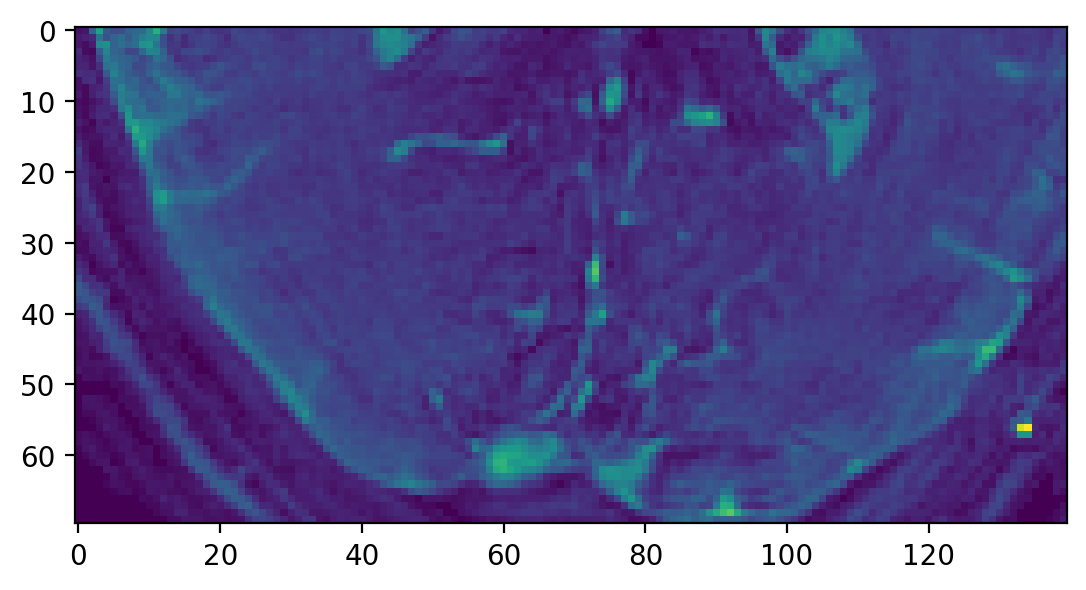

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat,savemat
import nibabel as nib

V=nib.load('data/CroppedData.nii')
V=np.array(V.get_fdata())
V=np.flipud(np.transpose(V,(1,0,2,3)))
# plt.imshow(np.mean(V[:,:,5,0:],axis=2))
plt.imshow(V[:,:,5,1])

print("Nvoxels : ",np.prod(V.shape[:-1]))


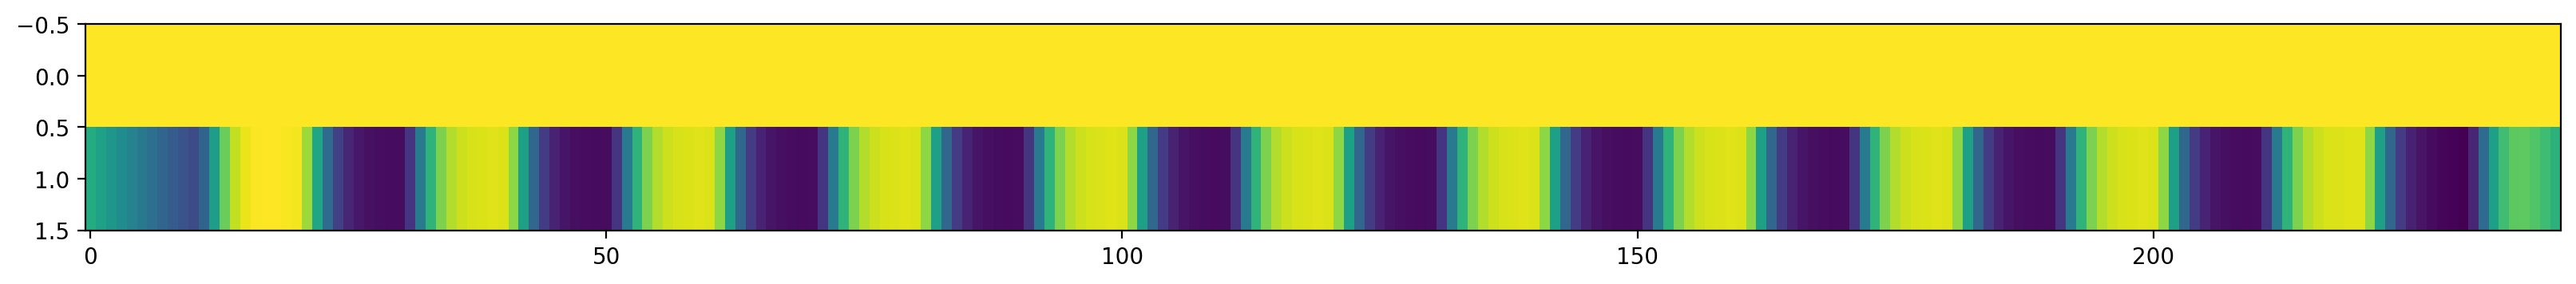

In [24]:
#construct design matrix two column
m=loadmat('data/model.mat')
D=np.ones((240,2))
D[:,1]=m['model'].flatten()
plt.figure(figsize=(20, 2))
plt.imshow(D.transpose(),aspect=10)

## GLM
$$
\text{data}= X \beta + \text{residual}

$$
$$
\beta_0 - \text{baseline} \newline
$$
$$
\beta_1 - \text{paradigm}
$$

$$
    Z_{scores} (\beta_1)=\dfrac{\beta_1-\bar{\beta_1}}{\sigma_{residual}}


\newline
    \sigma_{residual} - \text{standard deviation of residuals}
$$





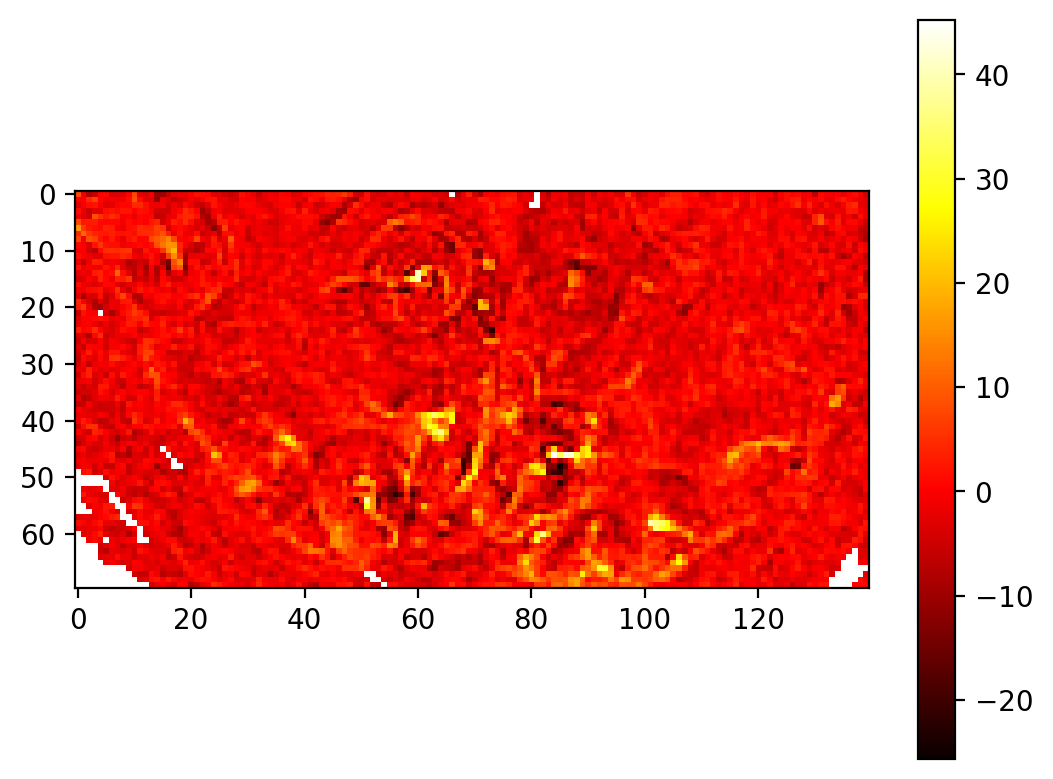

In [77]:
# Estimate beta real beta
def myGLM(D,V,constrast=[0,1]):
    # D is design matrix and V is time series data
    Dinv=np.linalg.pinv(D)
    imsz=V.shape
    V2=V.copy().reshape([imsz[0]*imsz[1]*imsz[2],imsz[3]])
    Beta=V2@Dinv.transpose()
    con=Beta@np.array(constrast).transpose()
    con=con.reshape(imsz[0:-1])
    res=V2-Beta@D.transpose()
    var=np.var(res,axis=1)
    var=var.reshape(imsz[0:-1])
    np.seterr(divide='ignore', invalid='ignore')
    ZScores=(con-np.mean(con))/np.sqrt(var)

    return Beta,ZScores
beta,Zscores=myGLM(D,V)
# plt.imshow(Zscores[:,:,1]*np.float32(Zscores[:,:,1]>10))
plt.imshow(Zscores[:,:,5],cmap=plt.cm.hot)
plt.colorbar()


(240,)


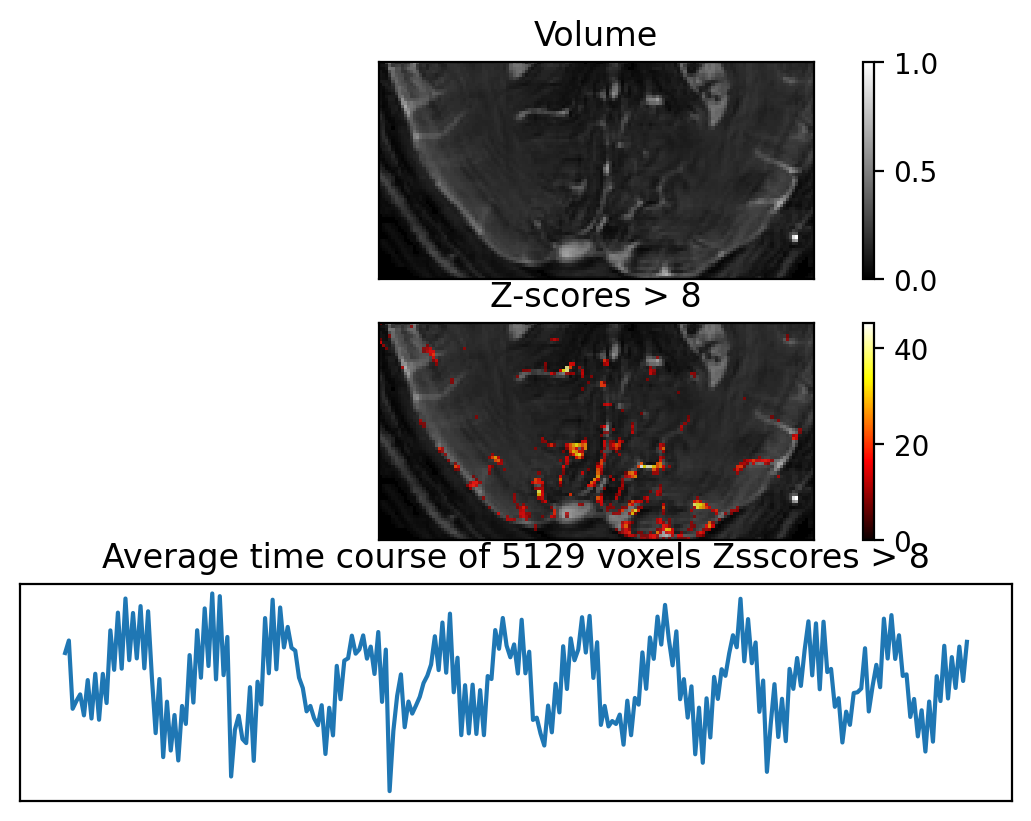

In [75]:
import matplotlib
plt.rcParams['figure.dpi'] = 200
def OverlayPlot(V,Zscores,alpha=0.6,Thres=4,slc=1):
    img=np.mean(V[:,:,slc,0:],axis=2)
    rows, cols = img.shape

    # process overlay
    ov=np.copy(Zscores[:,:,slc])
    ov[np.isnan(ov)]=0
    ov1=ov.copy()*np.float32(ov>Thres)

    # Display the output
    f, (ax0, ax1,ax2) = plt.subplots(3,1,
                                    subplot_kw={'xticks': [], 'yticks': []})
    ax0.imshow(img, cmap=plt.cm.gray)
    ax0.set_title("Volume")
    n0=matplotlib.colors.Normalize(np.min(img.flatten()),np.max(img.flatten()) )
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.gray),ax=ax0)
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.imshow(ov1, cmap=plt.cm.hot,alpha=0.8*np.float32(ov>Thres))
    ax1.set_title("Z-scores > %d" % (Thres))
    n2=matplotlib.colors.Normalize(np.nanmin(ov1.flatten()),np.nanmax(ov1.flatten()) )
    plt.colorbar(plt.cm.ScalarMappable(norm=n2,cmap=plt.cm.hot), ax=ax1)
    
    V1=V.copy()*np.reshape(np.float32(Zscores>Thres),(70,140,10,1))

    V2=V[Zscores>Thres,:]
    
    time_course=np.mean(V2,0).flatten()
    print(time_course.shape)
    ax2.plot(time_course)
    ax2.set_title("Average time course of %d voxels Zsscores > %d" % (V2.shape[0],Thres))

    plt.show()
OverlayPlot(V,Zscores,alpha=0.9,Thres=8,slc=5)

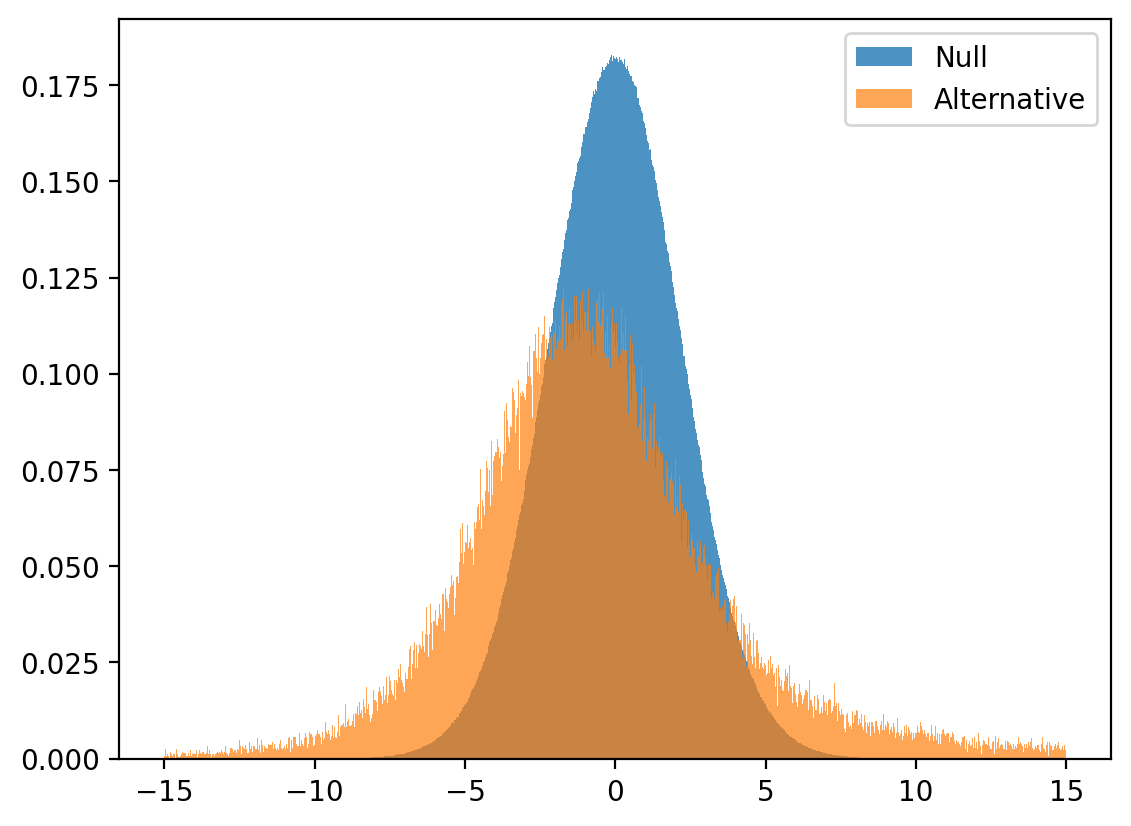

In [15]:
# Null Distribution
from random import shuffle
from scipy.io import savemat
import os.path

if 'Zscores_null' not in locals():
    if os.path.isfile("data/nulldist.mat"):
        Zscores_null=loadmat("data/nulldist.mat")['Zscores_null']   
    else:
        Nperm=200
        Zscores_null=np.zeros([V.shape[0],V.shape[1],V.shape[2], Nperm])
        D1=D.copy()
        for i in range(0,Nperm):
            print(f"doing iteration {i}")
            shuffle(D1[:,1])
            b,Zscores_null[...,i]=myGLM(D1,V)
        savemat("data/nulldist.mat",{"Zscores_null":Zscores_null})

hist=plt.hist(Zscores_null.flatten(),bins=np.linspace(-15,15,1000),density=True,label="Null",alpha=0.8)
hist2=plt.hist(Zscores.flatten(),bins=np.linspace(-15,15,1000),density=True,label="Alternative",alpha=0.7)
plt.legend()

## statistical inference

p-value- area of the null distribition (density) right to the chosen Z-score


In [14]:
# generate table
import pandas as pd
step_size=0.5
edges=np.arange(-25,25,step_size)
# print(edges)


hist=np.histogram(Zscores_null.flatten(),bins=edges,density=True)
hist2=np.histogram(Zscores.flatten(),bins=edges,density=False)

data=np.array([(hist[1][1:]),1-np.cumsum(hist[0]*step_size),hist2[0]])
df=pd.DataFrame(data.transpose(),columns=["Zscores","p-value","Nvoxels"])
df['Nvoxels'] = df['Nvoxels'].map('{:,.0f}'.format)
df['p-value'] = df['p-value'].map('{:,.8f}'.format)
display(df.iloc[len(edges)//2-1:-1:2])


,Zscores,p-value,Nvoxels
49,0.0,0.50005784,"5,273"
51,1.0,0.32388245,"4,500"
53,2.0,0.18104598,"3,430"
55,3.0,0.08646239,"2,538"
57,4.0,0.03529865,"1,818"
59,5.0,0.01239201,"1,252"
61,6.0,0.00376645,909
63,7.0,0.00100854,656
65,8.0,0.00023639,488
67,9.0,0.00004881,406
